# 第6章

In [2]:
import torch
print(torch.__version__)

2.2.1


## PyTorch

In [ ]:
x = torch.tensor(5.0)
y = 3 * x ** 2
print(y)
y.backward()
print(x.grad)

### 勾配法
以下のローゼンブロック関数の最小値を勾配法で求める(最適解は、$(x_0,x_1) = (1, 1)$)
$$
y = 100 \left(x_1 - x_0^2 \right)^2 + \left(x_0 - 1\right)^2
$$

In [3]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

x0 = torch.tensor(0.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad) # (0, 2)における勾配

tensor(-2.) tensor(400.)


In [4]:
# 勾配法
lr =0.001 # 学習率
iters = 10000 # 繰り返す回数
for i in range(iters):
    if i % 1000 == 0:
        print(x0.item(), x1.item())

    y = rosenbrock(x0, x1)

    y.backward()

    # 更新
    x0.data -= lr * x0.grad.data
    x1.data -= lr * x1.grad.data

    # 勾配リセット
    x0.grad.zero_()
    x1.grad.zero_()

print(x0.item(), x1.item())

0.0 2.0
0.6815015077590942 0.46292299032211304
0.8253857493400574 0.6804871559143066
0.8942827582359314 0.7992911338806152
0.9331904053688049 0.8705660700798035
0.9568046927452087 0.9152978658676147
0.9716982245445251 0.9440822601318359
0.9813036918640137 0.9628812670707703
0.98758465051651 0.9752733111381531
0.9917276501655579 0.983490526676178
0.9944759607315063 0.9889602065086365


## 線形回帰

線形回帰における損失関数(最小化する目的関数)は、
$$
L\left(W, b\right) = \frac{1}{N} \sum_{n=1}^{N}{\left(y^{(n)} - \left(W x^{(n)} + b \right)\right)^2}
$$
という平均2乗誤差である

In [6]:
import torch

torch.manual_seed(0)
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1) # ノイズとして(0,1)乱数を加える

W = torch.zeros((1, 1), requires_grad=True) # Wの形状:(1, 1)
b = torch.zeros(1, requires_grad=True) # bの形状(1,)

def predict(x):
    y = x @ W + b
    return y

def mean_squared_error(x0, x1):
    diff = x0 -x1
    N = len(diff)
    return torch.sum(diff ** 2) / N

lr = 0.1
iters = 100

for i in range(iters):
    y_hat = predict(x)
    loss = mean_squared_error(y, y_hat)

    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

    W.grad.zero_()
    b.grad.zero_()

    if i % 10 == 0:
        print(loss.item())

print(loss.item())
print('W=', W.item())
print('b=', b.item())


41.89796447753906
0.22483211755752563
0.0925208106637001
0.0888015553355217
0.08627457916736603
0.08435674756765366
0.0829005315899849
0.0817948430776596
0.08095530420541763
0.08031783998012543
0.07987643033266068
W= 2.2863590717315674
b= 5.3144850730896


可視化する

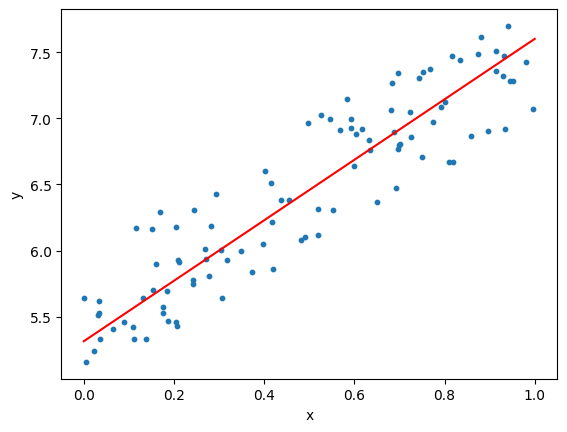

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10)
x = torch.tensor([[0.0], [1.0]])
y = W.detach().numpy() * x.detach().numpy() + b.detach().numpy()
plt.plot(x, y, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

平均二乗誤差を求める関数を`mean_squared_error`として実装したが以下のようにtorchを使ってかける

In [12]:
import torch.nn.functional as F
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)
loss = F.mse_loss(y, predict(x))

## ParameterとOptimizer
`torch.nn.Parameter`, `torch.nn.Module`, `torch.optim.SGD`を使って上記のコードをリファクタリングする
### Parameter, Module
ParameterはTensorクラスを継承したクラスである。引数にtensorインスタンスを与えてParameterのインスタンスを生成できる。

In [13]:
import torch
import torch.nn as nn

W = nn.Parameter(torch.zeros(1, 1))
b = nn.Parameter(torch.zeros(1))

print(W)
print(b)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


Parameterはデフォルトで`require_grad=True`となっている。さらに、ParameterはModuleと組み合わせることで以下のように使える

In [14]:
class Model(nn.Module): # Moduleクラスを継承
    def __init__(self):
        super().__init__()
        self.W = nn.Parameter(torch.zeros(1, 1))
        self.b = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        y = x @ self.W + self.b
        return y

model = Model()
# モデルにある全てのパラメータにアクセス
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


このように`parameters()`メソッドを用いてModuleクラスを継承したクラスからそれが持つ全てのパラメータにアクセスできる。さらに、順伝搬は`model.forward(x)`で得られるが、`model(x)`と省略できる

また、ここでの順伝搬は線形変換を計算しているため、PyTorchの`torch.nn.Linear`という線形変換のためのクラスを使用できる

In [17]:
class Model(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # Linearクラスを使用

    def forward(self, x):
        y = self.linear(x)
        return y

model = Model()

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.4089]], requires_grad=True)
Parameter containing:
tensor([-0.7591], requires_grad=True)


### optimizer
torch.optimを用いて上記の最適化手法を簡単にかける

In [20]:
x = torch.rand(100, 1)
y = 5 + 2 * x + torch.rand(100, 1)

lr = 0.1
iters = 100

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # optimizerの生成

for i in range(iters):
    y_hat = model(x)
    loss = nn.functional.mse_loss(y, y_hat)

    loss.backward() # 逆伝搬
    optimizer.step() # パラメータの更新
    optimizer.zero_grad() # 勾配をリセット


## ニューラルネットワークの実装
以下のような非線形なデータセットを考える
$$
y = \sin \left(2 \pi x \right) + \epsilon
$$
$\epsilon$は0から1までの値を取る乱数(ノイズ)である

In [21]:
import torch

torch.manual_seed(0)
x = torch.rand(100, 1)
y = torch.sin(2 * torch.pi * x) + torch.rand(100, 1)

2層で活性化関数としてシグモイド関数を使用するニューラルネットワークを実装する

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.linear1(x)
        y = F.sigmoid(y)
        y = self.linear2(y)
        return y

実際に学習する

In [26]:
lr = 0.2
iters = 10000

model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for i in range(iters):
    y_pred = model(x)
    loss = F.mse_loss(y, y_pred)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 1000 == 0:
        print(loss.item())

print(loss.item())

0.7568312287330627
0.23819884657859802
0.23317594826221466
0.2190137803554535
0.1875254511833191
0.12655875086784363
0.08644960075616837
0.08226139098405838
0.08166871219873428
0.0812397301197052
0.08085757493972778


可視化する

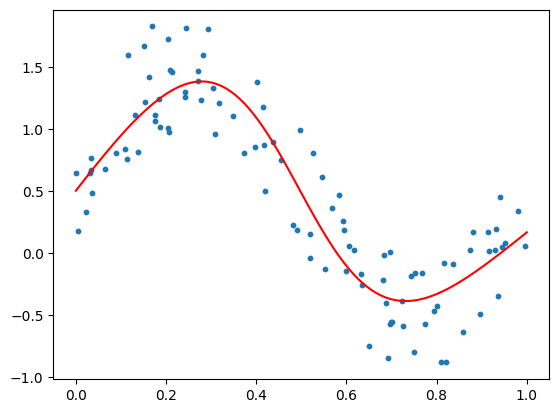

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x.detach().numpy(), y.detach().numpy(), s=10)
x = torch.linspace(0, 1, 100).reshape(-1, 1)
y = model(x).detach().numpy()
plt.plot(x, y, color='red')
plt.show()

## torchvisionとデータセット

In [28]:
import torchvision
print(torchvision.__version__)

0.17.1


### MNISTデータセット読み込み

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 763593.28it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 155484.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1348440.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5656332.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

size: 60000
type: <class 'PIL.Image.Image'>
label 5


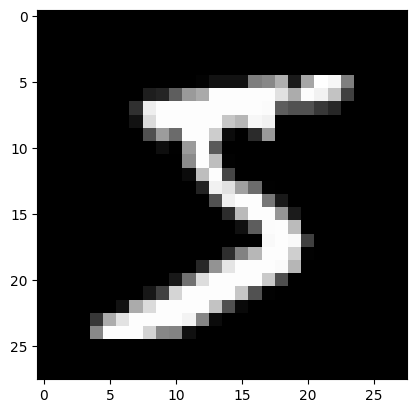

In [29]:
import torchvision
import matplotlib.pyplot as plt

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True, # Falseにするとテスト用データセットを読み込む
    transform=None,
    download=True
)

x, label = dataset[0]

print('size:', len(dataset))
print('type:', type(x))
print('label', label)

# 画像を表示
plt.imshow(x, cmap='gray')
plt.show()

### 前処理
MNISTデータセットはPILのImageクラスであるため、Tensorに変換する必要がある。その前処理は次のようにかける

In [30]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.ToTensor() # テンソルへ変換

dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform, # 前処理の指定
    download=True
)

x, label = dataset[0]
print('type:', type(x))
print('shape:', x.shape)

type: <class 'torch.Tensor'>
shape: torch.Size([1, 28, 28])


### データローダ
データセットからミニバッチとしてデータを取り出し、エポックごとにシャッフルをおこなう

In [31]:
import torch

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

for x, label in dataloader:
    print('x shape:', x.shape)
    print("label shape:", label.shape)
    break # 0番目のみ表示

x shape: torch.Size([32, 1, 28, 28])
label shape: torch.Size([32])
